# EDA <a id="1"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import textstat
from scipy import stats

import math
import numpy as np
import scipy as sp
import pandas as pd
from pandas import Timestamp

import random
import networkx as nx
from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mlp
plt.style.use('seaborn')
plt.rcParams['axes.grid'] = False
%matplotlib inline
tqdm.pandas()

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from googletrans import Translator
from nltk import WordNetLemmatizer
from polyglot.detect import Detector
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()


### Load the training, validation, and testing datasets

In [2]:
DATA_PATH = "../../data/"
os.listdir(DATA_PATH)

['jigsaw-toxic-comment-train-google-pt-cleaned.csv',
 'validation.csv',
 'jigsaw-toxic-comment-train-google-it-cleaned.csv',
 'jigsaw-toxic-comment-train-google-ru-cleaned.csv',
 'jigsaw-toxic-comment-train-google-ru.csv',
 'jigsaw-unintended-bias-train.csv',
 'train_cleaned.csv',
 'jigsaw-toxic-comment-train-google-es.csv',
 'jigsaw-toxic-comment-train-google-fr-cleaned.csv',
 'jigsaw-toxic-comment-train-google-es-cleaned.csv',
 'validation-processed-seqlen128.csv',
 'jigsaw-train-multilingual-coments-google-api.zip',
 'jigsaw-toxic-comment-train-processed-seqlen128.csv',
 'jigsaw-toxic-comment-train-google-fr.csv',
 'jigsaw-toxic-comment-train-google-it.csv',
 'jigsaw-unintended-bias-train-processed-seqlen128.csv',
 'validation_cleaned.csv',
 'jigsaw-toxic-comment-train-google-tr-cleaned.csv',
 'jigsaw-toxic-comment-train-google-tr.csv',
 'jigsaw-toxic-comment-train-google-pt.csv',
 'test.csv',
 'submission.csv',
 'test-processed-seqlen128.csv',
 'jigsaw-toxic-comment-train.csv',
 's

In [3]:
TEST_PATH = DATA_PATH + "test.csv"
VAL_PATH = DATA_PATH + "validation.csv"
TRAIN_PATH = DATA_PATH + "jigsaw-toxic-comment-train.csv"

val_data = pd.read_csv(VAL_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [4]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
val_data.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


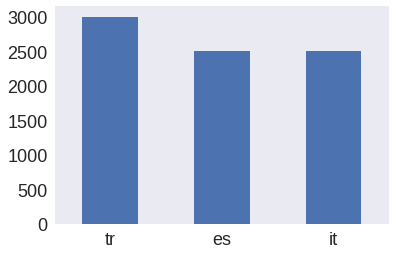

In [6]:
val_data.lang.value_counts().plot.bar(rot=0, fontsize=18)

In [7]:
test_data.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


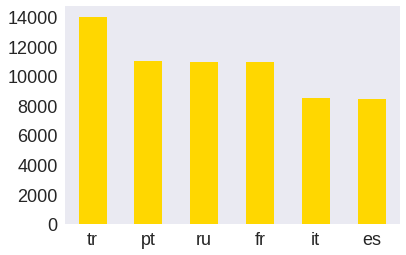

In [8]:
test_data.lang.value_counts().plot.bar(rot=0, fontsize=18, color="gold")

### Wordcloud of all comments

In [9]:
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

text = ' '.join([nonan(abstract) for abstract in train_data["comment_text"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)

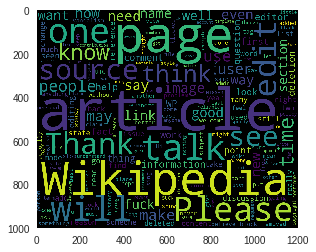

In [10]:
plt.imshow(wordcloud)

In the wordcloud above, we can see that the most common words are "wikipedia", "page" and "article". The observation is consistent with the balance analysis that indicates most of the comments are non-toxic.

## Languages <a id="1.2"></a>

Balance of the data

In [11]:
value_counts = train_data.toxic.value_counts()

df_toxic = pd.DataFrame({'comment type':['toxic', 'nontoxic'], 'count':value_counts})

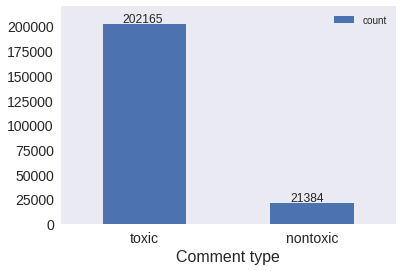

In [12]:
ax = df_toxic.plot.bar(x='comment type', y='count', rot=0, fontsize=14)
ax.set_ylim([0,220000])
ax.set_xlabel("Comment type", fontsize=16)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.12 , p.get_height()+2000), fontsize=12)

## Comment words <a id="1.3"></a>

Now, I will look at the number of words present in the comments.

### Distribution of word numbers of comments

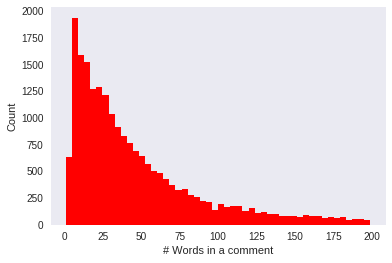

In [14]:
def new_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train_data["comment_words"] = train_data["comment_text"].apply(new_len)
# we sample 10% of the total data to get on overview of the distribution for the length of comments
nums = train_data.query("comment_words != 0 and comment_words < 200").sample(frac=0.1)["comment_words"]
plt.hist(nums, bins=50, color='r')
plt.xlabel("# Words in a comment")
plt.ylabel("Count")
plt.show()

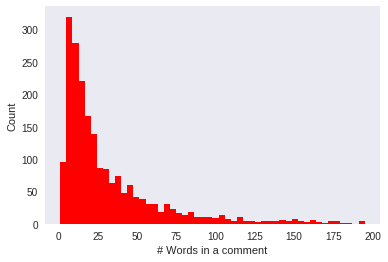

In [17]:
def new_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train_data["comment_words"] = train_data["comment_text"].apply(new_len)
# we sample 10% of the total data to get on overview of the distribution for the length of comments
nums = train_data.query("comment_words != 0 and comment_words < 200 and toxic==1").sample(frac=0.1)["comment_words"]
plt.hist(nums, bins=50, color='r')
plt.xlabel("# Words in a comment")
plt.ylabel("Count")
plt.show()

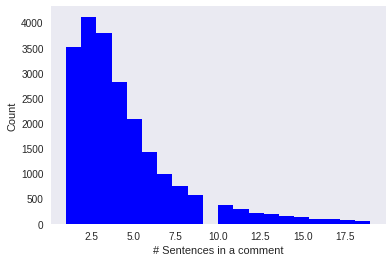

In [20]:
def new_len(x):
    if type(x) is str:
        return len(x.split('.'))
    else:
        return 0

train_data["comment_sentences"] = train_data["comment_text"].apply(new_len)
# we sample 10% of the total data to get on overview of the distribution for the length of comments
nums = train_data.query("comment_sentences != 0 and comment_sentences < 20 ").sample(frac=0.1)["comment_sentences"]
plt.hist(nums, color='b', bins=20)
plt.xlabel("# Sentences in a comment")
plt.ylabel("Count")
plt.show()

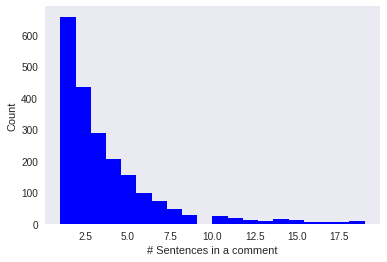

In [22]:
def new_len(x):
    if type(x) is str:
        return len(x.split('.'))
    else:
        return 0

train_data["comment_sentences"] = train_data["comment_text"].apply(new_len)
# we sample 10% of the total data to get on overview of the distribution for the length of comments
nums = train_data.query("comment_sentences != 0 and comment_sentences < 20 and toxic==1").sample(frac=0.1)["comment_sentences"]
plt.hist(nums, color='b', bins=20)
plt.xlabel("# Sentences in a comment")
plt.ylabel("Count")
plt.show()

From the plot above, we can see that the distribution has a strong rightward (positive) skew with  occuring at two sentences one comment.

## Targets <a id="1.6"></a>

Next we will visualize the targets in the dataset.

### Toxic Comments

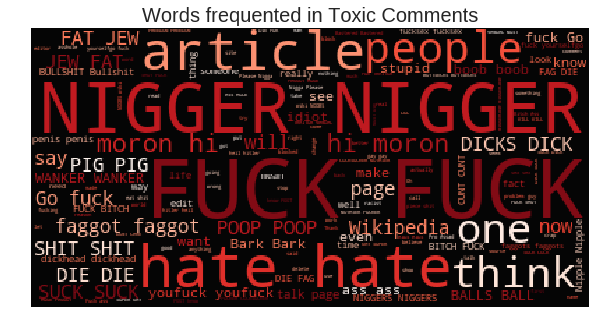

In [13]:
#Toxic comments
plt.figure(figsize=(10,10))
subset=train_data[train_data.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

In the above figure, we can find the most frequent words are more insulting or hateful words.